#### Review: Portfolio Optimization Practices and Theory (GMV Portfolio w/ Convex Optimization)

In [43]:
# In theory, the Maximum Sharpe Ratio portfolio would be optimal. However, because estimating this is often
# a game of...estimates, an alternative is the Global Minimum Variance portfolio.
 
# This is another 'remarkable' portfolio on the efficient frontier, other than the MSR. This portfolio analysis 
# does not require any future return estimates.

In [44]:
# '''!pip install jupyterthemes
# !jt -t monokai'''

#### Get Assets and Log Returns

In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Example: 5 assets
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
data = yf.download(tickers, start='2018-01-01', end='2023-01-01')['Close']
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.describe()


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,META,MSFT
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000918,0.000275,0.000406,-0.000326,0.000863
std,0.021106,0.022567,0.019769,0.027938,0.019565
min,-0.137708,-0.151398,-0.117667,-0.306391,-0.159454
25%,-0.009151,-0.010607,-0.008665,-0.011948,-0.008366
50%,0.001048,0.001228,0.001050,0.000680,0.001279
75%,0.012291,0.011661,0.010805,0.013488,0.010878
max,0.113157,0.126949,0.099380,0.162064,0.132929


In [46]:
#### Compute the Covariance Matrix
cov_matrix = log_returns.cov()
covariance


Ticker,AAPL,AMZN,GOOG,META,MSFT
Ticker,,,,,
AAPL,0.000445,0.000311,0.000293,0.000339,0.000320
AMZN,0.000311,0.000509,0.000307,0.000382,0.000316
GOOG,0.000293,0.000307,0.000391,0.000367,0.000312
META,0.000339,0.000382,0.000367,0.000781,0.000336
MSFT,0.000320,0.000316,0.000312,0.000336,0.000383


#### Solve Global Minimum Varian (GMV) Portfolio with Scipy.optimize()

In [47]:
cov_matrix = log_returns.cov().values
n_assets = len(tickers)

# Objective: portfolio variance                            # Our objective function (formula below) is quadratic 
def portfolio_variance(weights, cov_matrix):               # this problem can be solved using convex optimization.
    return np.dot(weights.T, np.dot(cov_matrix, weights))  # This is the formula to minimize.

# Constraints: fully invested                              # we're adding fully invested constraint.
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: long-only (no shorting)
bounds = [(0, 1) for _ in range(n_assets)]

# Initial guess: equal weights
w0 = np.ones(n_assets) / n_assets

# Solve
opt = minimize(portfolio_variance, w0, args=(cov_matrix,), method='SLSQP',
               bounds=bounds, constraints=constraints)

weights_gmv_opt = opt.x
weights_gmv_opt

array([0.2, 0.2, 0.2, 0.2, 0.2])

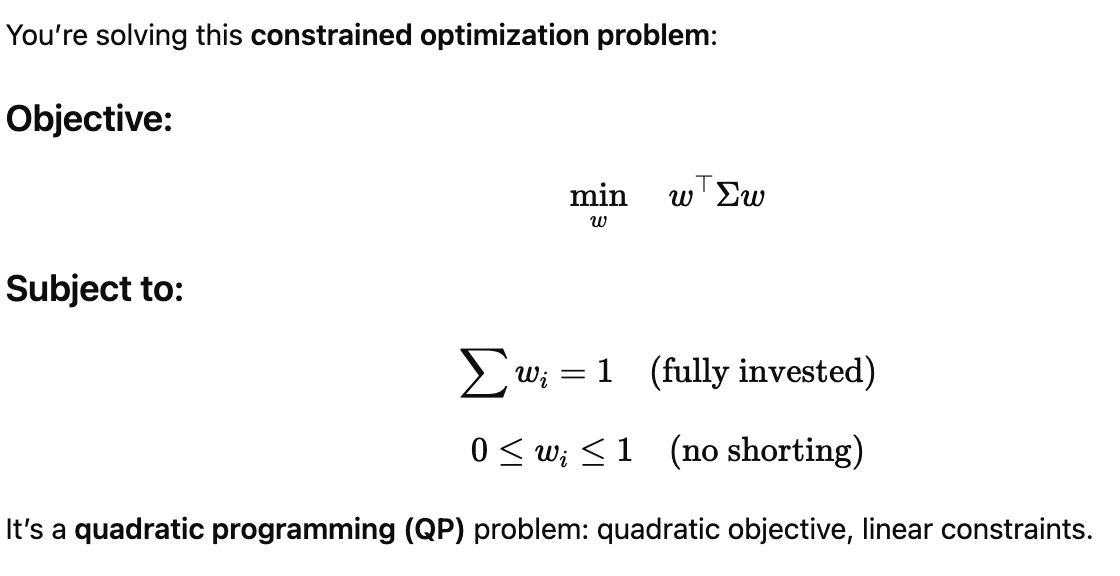

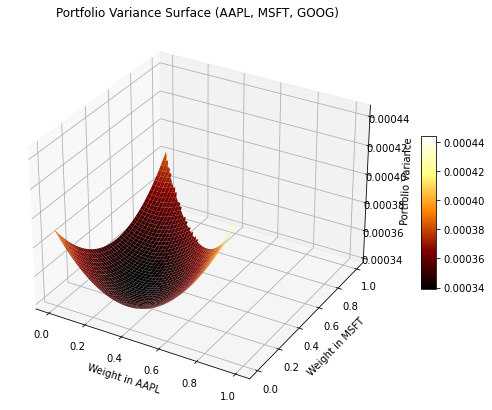

In [48]:
from mpl_toolkits.mplot3d import Axes3D

# Select 3 assets from your existing data  # this is for visualization purposes (3 dimensions)
selected_assets = ['AAPL', 'MSFT', 'GOOG']
cov_matrix_3 = log_returns[selected_assets].cov().values

# Set up grid of weights for Asset 1 and Asset 2
w1_vals = np.linspace(0, 1, 100)
w2_vals = np.linspace(0, 1, 100)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Var = np.zeros_like(W1)

# Calculate portfolio variance for each weight combination
for i in range(W1.shape[0]):     # rows of W1 = 100
    for j in range(W1.shape[1]): # cols of W1 = 100
        w1 = W1[i, j]
        w2 = W2[i, j]
        w3 = 1 - w1 - w2         # sum(w_i) = 1
        if w3 >= 0:
            w = np.array([w1, w2, w3])
            Var[i, j] = w.T @ cov_matrix_3 @ w
        else:
            Var[i, j] = np.nan  # invalid (w3 < 0)

# Plot the 3D variance surface
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(W1, W2, Var, cmap='afmhot', edgecolor='none')

ax.set_title('Portfolio Variance Surface (AAPL, MSFT, GOOG)')
ax.set_xlabel('Weight in AAPL')
ax.set_ylabel('Weight in MSFT')
ax.set_zlabel('Portfolio Variance')

fig.colorbar(surf, shrink=0.4, aspect=10)
plt.show()

# The shape is convex (a 3D bowl), confirming that the objective function 
# 𝑤.⊤Σ𝑤 is convex.


# The lowest point represents the minimum variance portfolio.